In [17]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import safeopt
import stageopt

mpl.rcParams['figure.figsize'] = (20.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 20

In [18]:
# Measurement noise
noise_var0 = 0.05 ** 2
noise_var1 = 1e-5
# noise_var2 = 1e-5
# noise_var3 = 1e-5

# Bounds on the inputs variable
bounds = [(0., 1.), (0., 1.)]

# Define Kernel
kernel0 = GPy.kern.Matern32(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)
kernel1 = kernel0.copy()
# kernel2 = kernel0.copy()
# kernel3 = kernel0.copy()

# Initial safe point
x0 = np.zeros((1, len(bounds)))

# Generate function with safe initial point at x=0
def sample_safe_fun():
    fun_f = safeopt.sample_gp_function(kernel0, bounds, noise_var0, 25)
    while True:
        fun_s1 = safeopt.sample_gp_function(kernel1, bounds, noise_var1, 25)
        if fun_s1([0., 0.], noise=False) > 1:
            break
            
    def combined_fun(x, noise=True):
        return np.hstack([fun_f(x, noise), fun_s1(x, noise)])
    return combined_fun

In [ ]:
# Define the objective function
fun = sample_safe_fun()

# The statistical model of our objective function and safety constraint
y0 = fun(x0)
gp_safe_f = GPy.models.GPRegression(x0, y0[:, 0, None], kernel0, noise_var=noise_var0)
gp_stage_f = GPy.models.GPRegression(x0, y0[:, 0, None], kernel0, noise_var=noise_var0)
gp_safe_s1 = GPy.models.GPRegression(x0, y0[:, 1, None], kernel1, noise_var=noise_var1)
gp_stage_s1 = GPy.models.GPRegression(x0, y0[:, 1, None], kernel1, noise_var=noise_var1)

# The optimization routine
# opt = safeopt.SafeOptSwarm(gp, 0., bounds=bounds, threshold=0.2)
parameter_set = safeopt.linearly_spaced_combinations(bounds, 25)
safe_opt = safeopt.SafeOpt([gp_safe_f, gp_safe_s1], parameter_set, [-np.inf, 0.], lipschitz=None, threshold=0.2)
stage_opt = stageopt.StageOpt([gp_stage_f, gp_stage_s1], parameter_set, [-np.inf, 0.], lipschitz=None, threshold=0.2, switch_time=10)

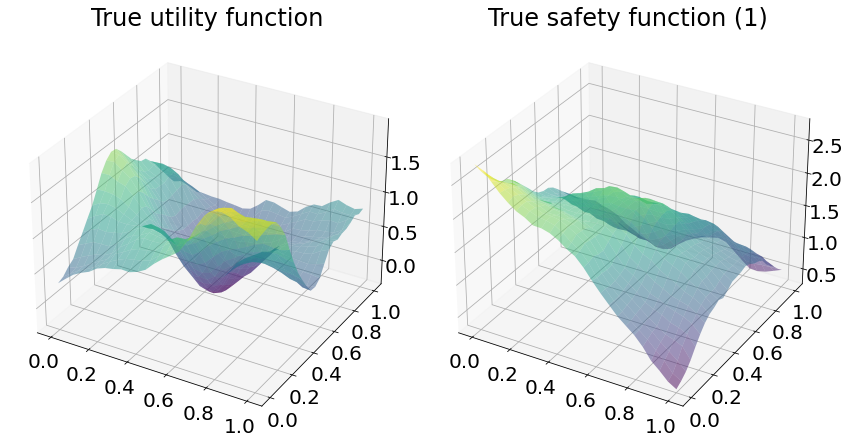

Maximum utility in the safe region: 1.9869705271435123


In [20]:
# 绘制真实函数
X = np.linspace(bounds[0][0], bounds[0][1], 25)
Y = np.linspace(bounds[1][0], bounds[1][1], 25)
X, Y = np.meshgrid(X, Y)
Z = np.array([fun([x, y], noise=False).flatten() for x, y in zip(X.ravel(), Y.ravel())])

# Reshape Z for utility and safety components
Z_f = Z[:, 0].reshape(X.shape)  # Utility function
Z_s1 = Z[:, 1].reshape(X.shape)  # Safety function (1)

# 创建图形对象
fig = plt.figure(figsize=(12, 12))

# 创建 3D 子图
ax_f = fig.add_subplot(121, projection='3d')  # 1st subplot for utility function
ax_s1 = fig.add_subplot(122, projection='3d')  # 2nd subplot for safety function

# 绘制真实函数
ax_f.plot_surface(X, Y, Z_f, alpha=0.5, cmap='viridis')
ax_f.set_title("True utility function")
ax_s1.plot_surface(X, Y, Z_s1, alpha=0.5, cmap='viridis')
ax_s1.set_title("True safety function (1)")

# 显示图形
plt.tight_layout()
plt.show()

# 计算安全区域中，真实效用函数的最大值
safe_region = np.where(Z_s1 > 0)
safe_utility = Z_f[safe_region]
safe_max_utility = np.max(safe_utility)
print("Maximum utility in the safe region:", safe_max_utility)

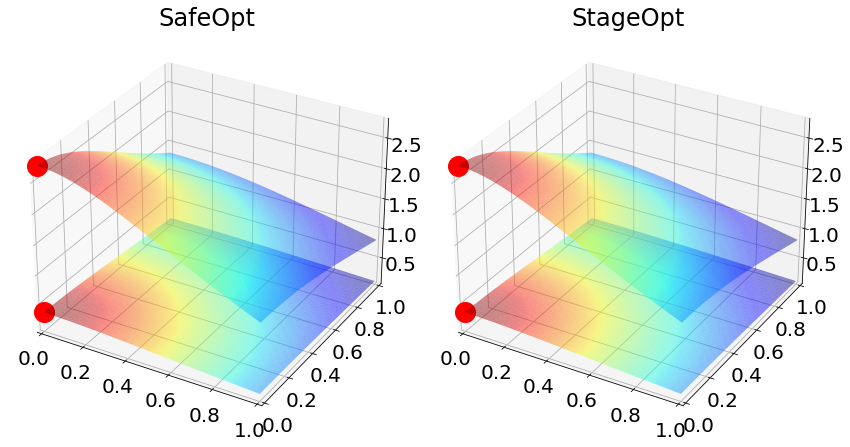

In [21]:
def plot_gp():
    # 创建图形对象
    fig = plt.figure(figsize=(12, 12))

    # 创建第一个 3D 子图
    ax1 = fig.add_subplot(121, projection='3d')  # 211 表示 2 行 1 列，第 1 个子图
    safe_opt.plot(100, axis=ax1, plot_3d=True)  # 在第一个子图上绘制
    ax1.set_title("SafeOpt")

    # 创建第二个 3D 子图
    ax2 = fig.add_subplot(122, projection='3d')  # 212 表示 2 行 1 列，第 2 个子图
    stage_opt.plot(100, axis=ax2, plot_3d=True)  # 在第二个子图上绘制
    ax2.set_title("StageOpt")

    # 显示图形
    plt.tight_layout()
    plt.show()

plot_gp()

Time step: 5
Best reward: SafeOpt: 1.8535645122025335, StageOpt: 1.0705747607285843
Regret: SafeOpt: 0.1334060149409788, StageOpt: 0.916395766414928


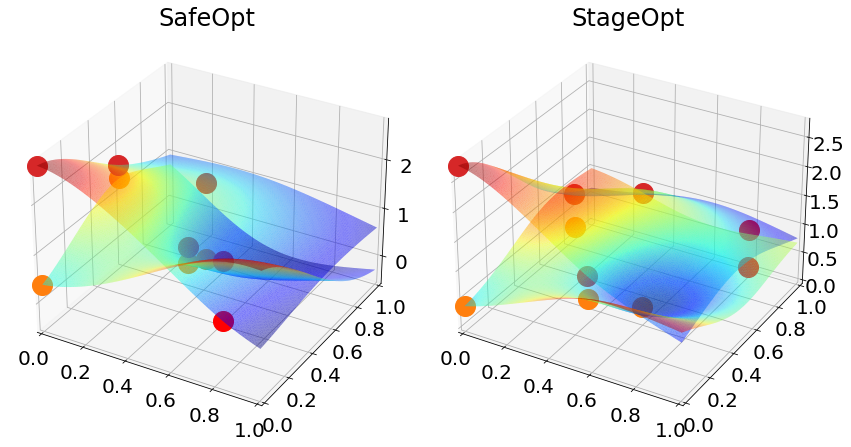

Time step: 10
Best reward: SafeOpt: 1.8525766197770714, StageOpt: 1.6685632264292765
Regret: SafeOpt: 0.13439390736644086, StageOpt: 0.31840730071423584


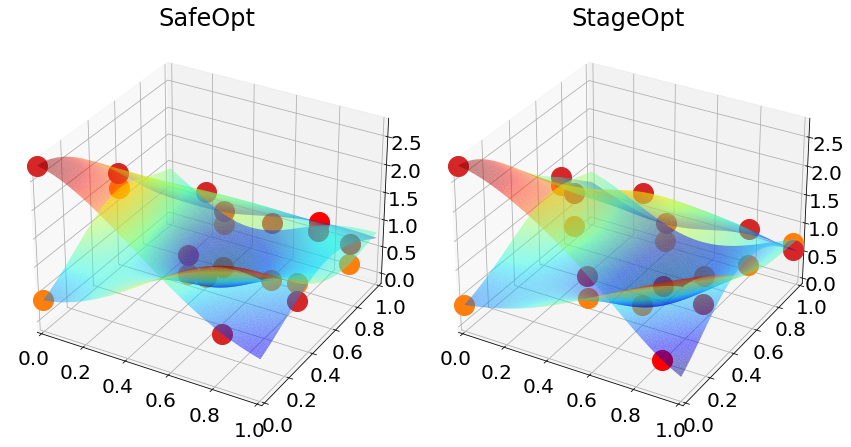

Time step: 15
Best reward: SafeOpt: 1.8425791948565093, StageOpt: 1.6699593190819084
Regret: SafeOpt: 0.14439133228700296, StageOpt: 0.3170112080616039


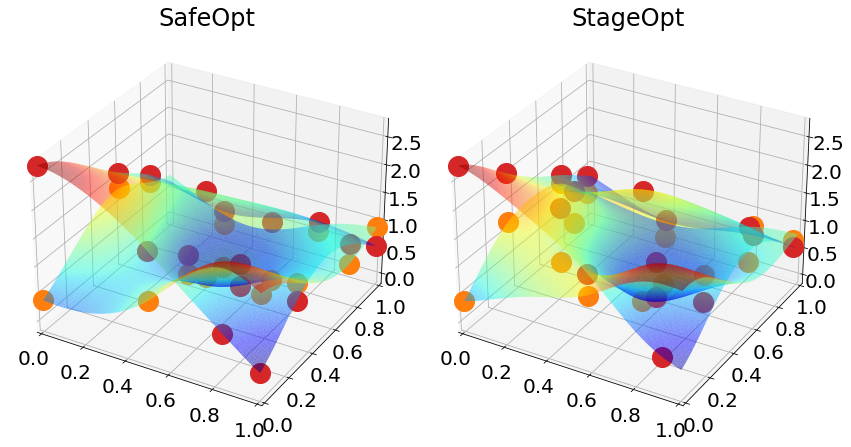

Time step: 20
Best reward: SafeOpt: 1.844097230253615, StageOpt: 1.8345651230219004
Regret: SafeOpt: 0.14287329688989736, StageOpt: 0.15240540412161185


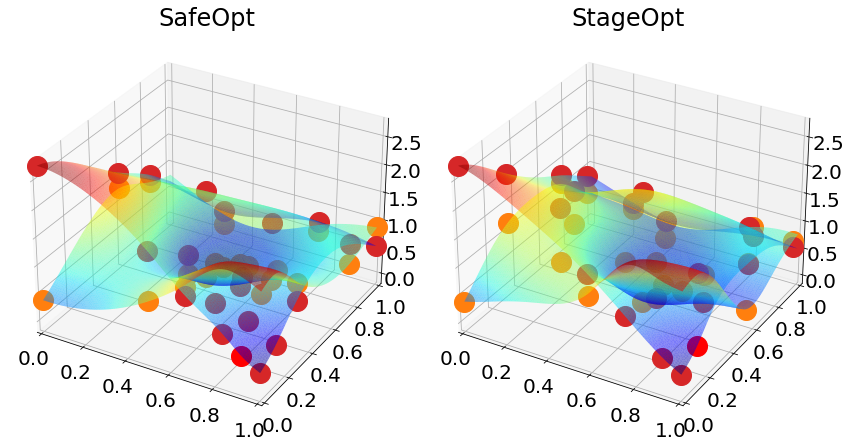

Time step: 25
Best reward: SafeOpt: 1.8846718181874709, StageOpt: 1.9084579266445074
Regret: SafeOpt: 0.10229870895604143, StageOpt: 0.07851260049900488


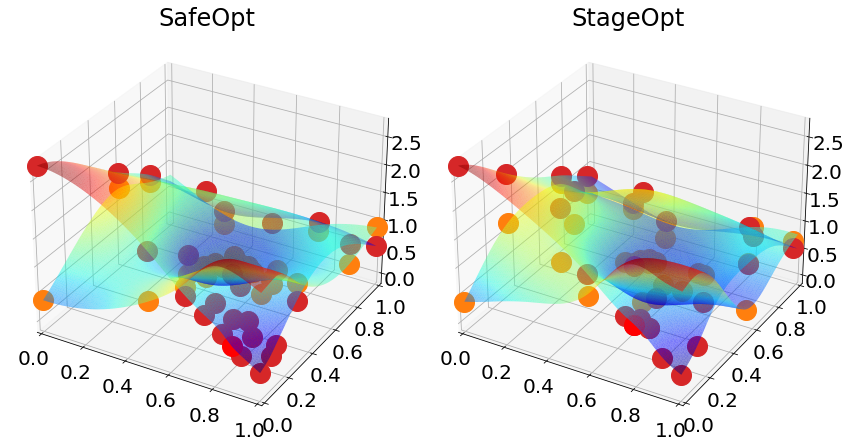

Time step: 30
Best reward: SafeOpt: 1.9106847613147044, StageOpt: 1.9317897699095532
Regret: SafeOpt: 0.07628576582880786, StageOpt: 0.0551807572339591


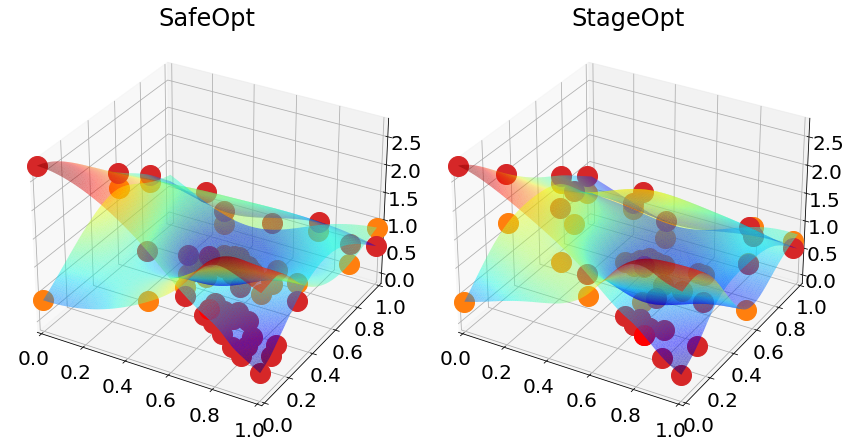

In [ ]:
# Storage for the results
reward_safe, reward_stage = [], []
regret_safe, regret_stage = [], []

# First query point
reward_safe.append(safe_opt.get_maximum()[1])
reward_stage.append(stage_opt.get_maximum()[1])
regret_safe.append(safe_max_utility - safe_opt.get_maximum()[1])
regret_stage.append(safe_max_utility - stage_opt.get_maximum()[1])

for i in range(19):
    # Obtain next query point
    x_next = safe_opt.optimize()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    safe_opt.add_new_data_point(x_next, y_meas)

    x_next = stage_opt.optimize()[0]
    y_meas = fun(x_next)
    stage_opt.add_new_data_point(x_next, y_meas)
    
    reward_safe.append(safe_opt.get_maximum()[1])
    reward_stage.append(stage_opt.get_maximum()[1])
    regret_safe.append(safe_max_utility - safe_opt.get_maximum()[1])
    regret_stage.append(safe_max_utility - stage_opt.get_maximum()[1])

    if safe_opt.t % 5 == 0:
        print("Time step:", safe_opt.t)
        print(f"Best reward: SafeOpt: {safe_opt.get_maximum()[1]}, StageOpt: {stage_opt.get_maximum()[1]}")
        print(f"Regret: SafeOpt: {safe_max_utility - safe_opt.get_maximum()[1]}, StageOpt: {safe_max_utility - stage_opt.get_maximum()[1]}")
        plot_gp()


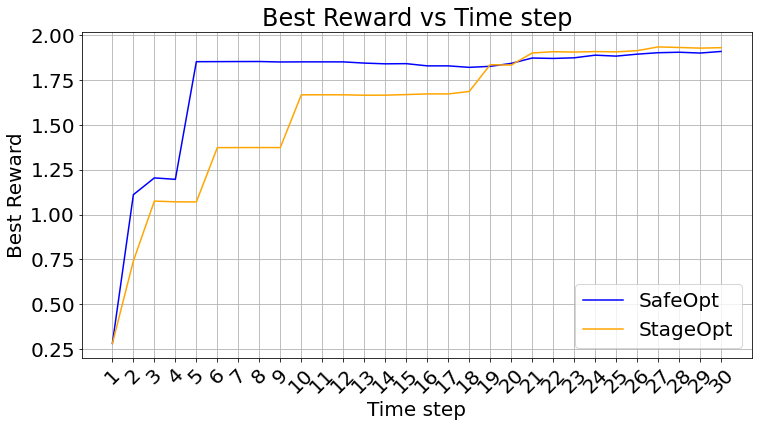

In [23]:
# Plot reward
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(reward_safe) + 1), reward_safe, label='SafeOpt', color='blue')
plt.plot(range(1, len(reward_stage) + 1), reward_stage, label='StageOpt', color='orange')
plt.xticks(range(1, len(regret_safe) + 1), rotation=45)  # 设置横坐标刻度和旋转角度
plt.xlabel('Time step')
plt.ylabel('Best Reward')
plt.title('Best Reward vs Time step')
plt.legend()
plt.grid()
plt.show()

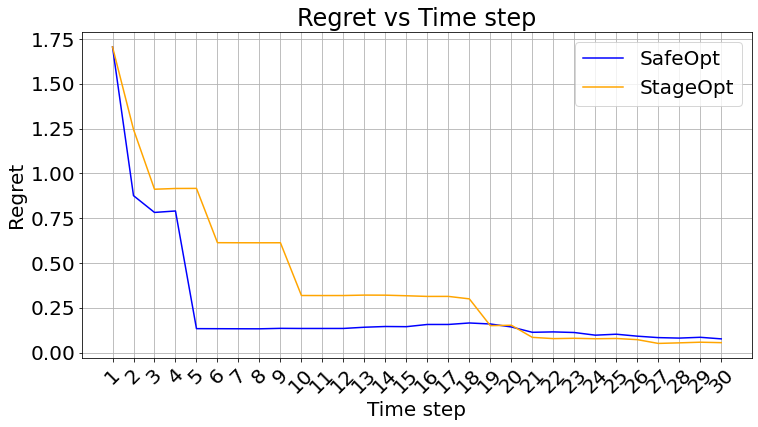

In [24]:
# 自定义横坐标网格大小
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(regret_safe) + 1), regret_safe, label='SafeOpt', color='blue')
plt.plot(range(1, len(regret_stage) + 1), regret_stage, label='StageOpt', color='orange')
plt.xticks(range(1, len(regret_safe) + 1), rotation=45)  # 设置横坐标刻度和旋转角度
plt.xlabel('Time step')
plt.ylabel('Regret')
plt.title('Regret vs Time step')
plt.legend()
plt.grid()

plt.show()